## MLP, SGD - LOOP

- Loop by strategy, no encoding, smaller x-variable dataset

In [ ]:
import pandas as pd
import os
from datetime import timedelta
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import AdaBoostRegressor

# File paths for EUR and GBP datasets
eur_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\Method_1_Results\Combined_Features\Merged_Strategy_Data_EUR.csv'
gbp_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\Method_1_Results\Combined_Features\Merged_Strategy_Data_GBP.csv'

# Step 1: Load the EUR and GBP datasets
eur_data = pd.read_csv(eur_file)
gbp_data = pd.read_csv(gbp_file)

# Step 2: Combine the datasets by appending GBP data to EUR data
combined_data = pd.concat([eur_data, gbp_data], ignore_index=True)

# Step 3: Sort the combined data by Date, then by strategy_name
combined_data.sort_values(by=['Date', 'strategy_name'], inplace=True)

# Step 4: Define columns to keep (exclude 'classifier' and others if needed)
columns_to_keep = [
    'Date', 'strategy_name', 'Rank', 'Long_Short', 'Cumulative_VWAP', 'Cumulative_Volume', 'Precision',
    'Combined_Ratio', 'Downside_Ratio', 'Lower_Band', 'Band_Width', 'Upper_Band', 'Rolling_Mean', 
    'rolling_Peak_30', 'Close', 'EMA_4800', 'EMA_1200', 'Crossover', 'SMA_4800', 'CrossUp', 'PSAR', 
    'EMA_240', 'MACD', 'PSAR_direction', 'L14', 'PnL_slope_30', 'H14', 'TR_Smooth', 'SMA_1200', 'DM_down_Smooth', 
    'DM_up_Smooth', 'DI_up', 'Rolling_Max_Recovery_Time', 'DI_down', 'rolling_std_30', 'sharpe_ratio', 'OBV', 'K_PCT', 
    'Drawdown', 'CMF'
]

# Step 5: Filter the combined data to keep only the necessary columns
combined_data = combined_data[columns_to_keep]

def generate_periods_M(start_date, end_date):
    """Generate periods for walk-forward validation with 1-year training and 1-month test."""
    periods = []
    current_start = pd.to_datetime(start_date)
    final_start = pd.to_datetime(end_date)
    
    while current_start <= final_start:
        train_start = current_start
        train_end = train_start + pd.DateOffset(years=1) - timedelta(days=1)
        test_start = train_end + timedelta(days=1)
        test_end = test_start + pd.DateOffset(months=1) - timedelta(days=1)
        
        if test_end > final_start:
            break

        periods.append({
            'train_start': train_start,
            'train_end': train_end,
            'test_start': test_start,
            'test_end': test_end
        })
        
        current_start += pd.DateOffset(months=1)
    
    return periods

def slice_data_by_period(data, periods, date_col):
    """Slice data by the given periods."""
    slices = []
    for period in periods:
        train_data = data[(data[date_col] >= period['train_start']) & (data[date_col] <= period['train_end'])]
        test_data = data[(data[date_col] >= period['test_start']) & (data[date_col] <= period['test_end'])]
        slices.append((train_data, test_data))
    return slices

def walk_forward_validation(x_data, y_data, periods, strategy_name):
    """Execute walk-forward validation using the provided pipeline."""
    x_data.loc[:, 'Date'] = pd.to_datetime(x_data['Date'])
    y_data.loc[:, 'Date'] = pd.to_datetime(y_data['Date'])
    
    x_slices = slice_data_by_period(x_data, periods, 'Date')
    y_slices = slice_data_by_period(y_data, periods, 'Date')

    models = [
        ('MLP', MLPRegressor(max_iter=1000, random_state=42)),
        ('SGD', SGDRegressor(random_state=42)),
        ('ABR', AdaBoostRegressor(random_state=42))
    ]

    predictions = []

    for period_idx, ((x_train, x_test), (y_train, y_test)) in enumerate(zip(x_slices, y_slices)):
        X_train = x_train.drop(columns=['Date', 'strategy_name'])
        Y_train = y_train['Rank']
        X_test = x_test.drop(columns=['Date', 'strategy_name'])
        Y_test = y_test['Rank']
        
        # Standardize the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for name, model in models:
            model.fit(X_train, Y_train)
            
            y_pred = model.predict(X_test)
            period_predictions = pd.DataFrame({
                'Date': x_test['Date'].values,
                'Strategy': strategy_name,
                'Model': name,
                'y_actual': Y_test.values,
                'y_pred': y_pred
            })
            predictions.append(period_predictions)
    
    return pd.concat(predictions)

# Example execution (using data from walk-forward validation)
all_predictions = []

# List of unique strategies
unique_strategies = combined_data['strategy_name'].unique()

# Iterate over each strategy
for strategy in unique_strategies:
    strategy_data = combined_data[combined_data['strategy_name'] == strategy].reset_index(drop=True)

    x = strategy_data
    y = strategy_data[['Date', 'Rank']]
    
    start_date = '2021-06-01'
    end_date = '2023-12-31'
    periods = generate_periods_M(start_date, end_date)

    strategy_predictions = walk_forward_validation(x, y, periods, strategy)
    all_predictions.append(strategy_predictions)

# Combine all predictions into a single DataFrame
final_predictions = pd.concat(all_predictions)

# Save the predictions to a CSV file
output_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\ALL_LOOP_PREDICTIONS.csv'
final_predictions.to_csv(output_file, index=False)

### Process Results

In [1]:
import pandas as pd
import os
from sklearn.metrics import mean_squared_error

# File paths
file_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\FINAL_SUBMISSION\ALL_LOOP_PREDICTIONS.csv'
net_pnl_file_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\Net_PnL_Results\net_pnl_change_D.csv'
output_file = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\FINAL_SUBMISSION\FINAL_LOOP.csv'

# Step 1: Load the predictions CSV
df = pd.read_csv(file_path, parse_dates=['Date'])

# Step 2: Rename the 'Strategy' column to 'strategy_name'
df.rename(columns={'Strategy': 'strategy_name'}, inplace=True)

# Step 3: Extract Month and Year from Date
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Step 4: Pivot the data to get the average y_actual and y_pred per month, year, and model
pivot_df = df.pivot_table(index=['Month', 'Year', 'Model', 'strategy_name'], values=['y_actual', 'y_pred'], aggfunc='mean').reset_index()

# Step 5: Round the predicted values to the nearest integer
pivot_df['y_pred'] = pivot_df['y_pred'].round()

# Function to get the top strategies
def get_top_strategies(pivot_df, value_column, top_n=10):
    top_strategies = {}
    for month in range(1, 13):
        for year in pivot_df['Year'].unique():
            for model in pivot_df['Model'].unique():
                subset = pivot_df[(pivot_df['Month'] == month) & (pivot_df['Year'] == year) & (pivot_df['Model'] == model)]
                top_strategies_list = subset.nlargest(top_n, value_column)['strategy_name'].unique().tolist()
                if (month, year, model) not in top_strategies:
                    top_strategies[(month, year, model)] = set()
                top_strategies[(month, year, model)].update(top_strategies_list)
    return top_strategies

# Step 6: Get the top strategies for y_actual and y_pred
top_actual_strategies = get_top_strategies(pivot_df, 'y_actual')
top_pred_strategies = get_top_strategies(pivot_df, 'y_pred')

# Step 7: Combine the strategies
combined_strategies = {}
for key in top_actual_strategies.keys():
    combined_strategies[key] = top_actual_strategies[key].union(top_pred_strategies[key])

# Step 8: Calculate MSE for the combined strategies
results = []
for (month, year, model), strategies in combined_strategies.items():
    for strategy in strategies:
        subset = pivot_df[(pivot_df['Month'] == month) & (pivot_df['Year'] == year) & (pivot_df['Model'] == model) & (pivot_df['strategy_name'] == strategy)]
        if not subset.empty:
            mse = mean_squared_error(subset['y_actual'], subset['y_pred'])
            y_actual_val = subset['y_actual'].values[0] if subset['y_actual'].values[0] != 0 else None
            y_pred_val = subset['y_pred'].values[0] if subset['y_pred'].values[0] != 0 else None
            results.append({
                'Month': month,
                'Year': year,
                'Model': model,
                'strategy_name': strategy,
                'y_actual': y_actual_val,
                'y_pred': y_pred_val,
                'MSE': mse
            })

# Step 9: Filter out rows where both y_actual and y_pred are None
results_df = pd.DataFrame(results)
results_df = results_df.dropna(subset=['y_actual', 'y_pred'], how='all')

# Step 10: Define the date range from 2022-06-01 to 2022-12-31
date_range = pd.date_range(start='2022-06-01', end='2023-12-31')

# Function to extrapolate monthly data to daily data
def extrapolate_to_daily(df):
    daily_data = []
    unique_combinations = df[['strategy_name', 'Model']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
        strategy_name = row['strategy_name']
        model = row['Model']
        
        for date in date_range:
            daily_row = {
                'strategy_name': strategy_name,
                'Model': model,
                'Date': date
            }
            daily_data.append(daily_row)
    
    daily_df = pd.DataFrame(daily_data)
    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    merged_df = pd.merge(daily_df, df, on=['strategy_name', 'Model', 'Date'], how='left')
    
    return merged_df

# Step 11: Extrapolate the data to daily
daily_df = extrapolate_to_daily(results_df)

# Step 12: Group by strategy_name, Model, and Month and forward fill within each month
daily_df['Month'] = daily_df['Date'].dt.month
daily_df['Year'] = daily_df['Date'].dt.year
daily_df[['y_actual', 'y_pred', 'MSE']] = (
    daily_df.groupby(['strategy_name', 'Model', 'Month', 'Year'])[['y_actual', 'y_pred', 'MSE']].ffill()
)

# Step 13: Replace remaining NaNs with 0
# Replace NaNs with 0 for the specified columns
daily_df['y_actual'] = daily_df['y_actual'].fillna(0)
daily_df['y_pred'] = daily_df['y_pred'].fillna(0)
daily_df['MSE'] = daily_df['MSE'].fillna(0)


# Step 14: Load net PnL data and merge with the daily predictions
net_pnl_df = pd.read_csv(net_pnl_file_path, parse_dates=['Period'])
net_pnl_df.rename(columns={'Period': 'Date'}, inplace=True)
df = pd.merge(daily_df, net_pnl_df[['Date', 'strategy_name', 'net_pnl_change']],
              on=['Date', 'strategy_name'], how='inner')

# Step 15: Add a new column to represent the next month's data
df['next_month'] = df['Date'] + pd.DateOffset(months=1)
df = pd.merge(df, df[['Date', 'strategy_name', 'net_pnl_change']], 
              left_on=['next_month', 'strategy_name'], 
              right_on=['Date', 'strategy_name'], 
              suffixes=('', '_next_month'), 
              how='left')

# Step 16: Remove duplicates based on Date, strategy_name, and Model
df = df.drop_duplicates(subset=['Date', 'strategy_name', 'Model'])

# Step 17: Ensure the next_month column is properly formatted
df['next_month'] = pd.to_datetime(df['next_month'], errors='coerce')
df['next_month'] = df['next_month'].dt.month

# Step 18: Save the final dataframe to a CSV file
df.to_csv(output_file, index=False)

#### Daily Net PnL Change Graph

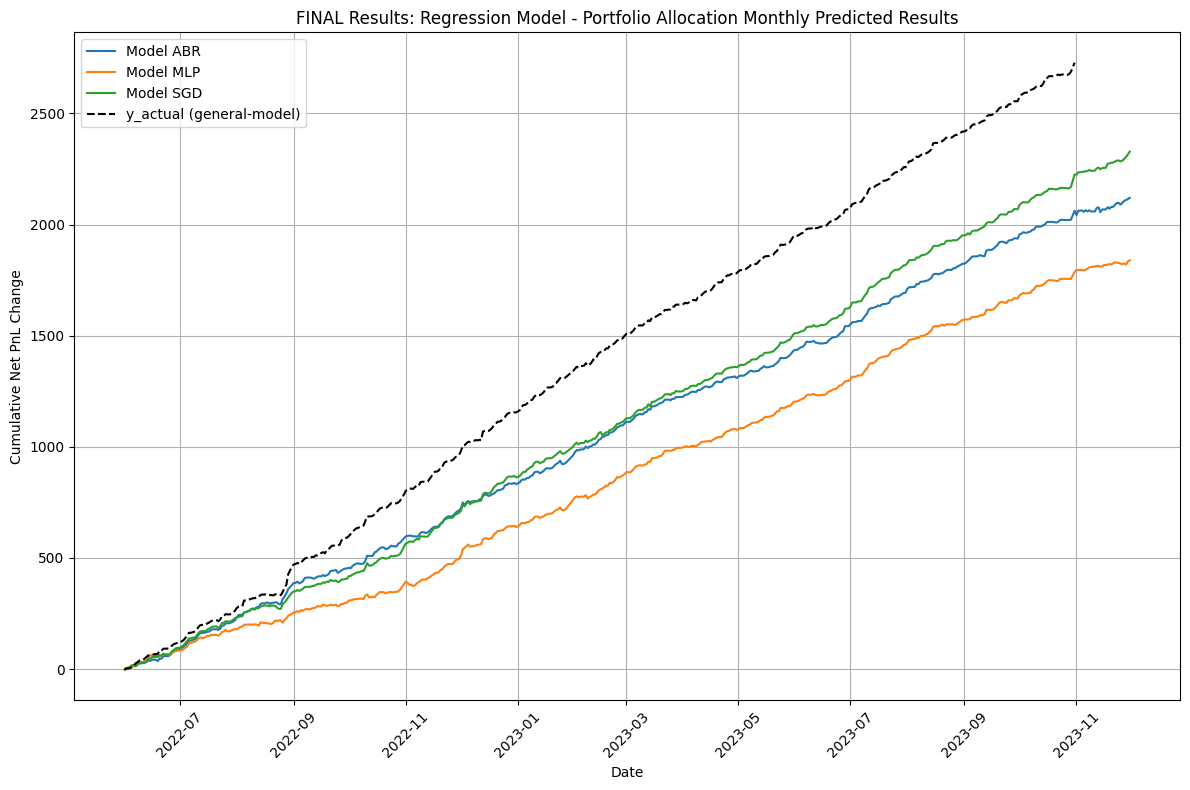

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

file_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\FINAL_SUBMISSION\FINAL_LOOP.csv'

# Load the CSV file
df = pd.read_csv(file_path, parse_dates=['Date'])

# Function to plot the cumulative net PnL change for each model on a daily basis
def plot_cumulative_net_pnl_change(df):
    models = df['Model'].unique()
    plt.figure(figsize=(12, 8))
    
    for model in models:
        model_df = df[df['Model'] == model]
        
        # Filter out strategies with non-zero and non-NaN y_pred
        valid_strategies = model_df[model_df['y_pred'].notna() & (model_df['y_pred'] != 0)]
        
        # Group by Date and calculate the sum of net_pnl_change and count the number of strategies
        grouped_df = valid_strategies.groupby('Date').agg(
            net_pnl_sum=('net_pnl_change_next_month', 'sum'),
            strategy_count=('net_pnl_change_next_month', 'count')
        ).reset_index()
        
        # Calculate the cumulative net_pnl_change
        grouped_df['avg_net_pnl_change'] = grouped_df['net_pnl_sum'] / grouped_df['strategy_count']
        grouped_df['cumulative_net_pnl_change'] = grouped_df['avg_net_pnl_change'].cumsum()

        # Plot the cumulative net PnL change
        plt.plot(grouped_df['Date'], grouped_df['cumulative_net_pnl_change'], label=f'Model {model}')

    # Plot y_actual (general-model)
    valid_actual_strategies = df[df['y_actual'].notna() & (df['y_actual'] != 0)]
    grouped_actual_df = valid_actual_strategies.groupby('Date').agg(
        net_pnl_sum=('net_pnl_change_next_month', 'sum'),
        strategy_count=('net_pnl_change_next_month', 'count')
    ).reset_index()
    
    grouped_actual_df['avg_net_pnl_change'] = grouped_actual_df['net_pnl_sum'] / grouped_actual_df['strategy_count']
    grouped_actual_df['cumulative_net_pnl_change'] = grouped_actual_df['avg_net_pnl_change'].cumsum()
    
    plt.plot(grouped_actual_df['Date'], grouped_actual_df['cumulative_net_pnl_change'], color='black', linestyle='--', label='y_actual (general-model)')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Net PnL Change')
    plt.title('FINAL Results: Regression Model - Portfolio Allocation Monthly Predicted Results')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot cumulative net PnL change for each model and y_actual
plot_cumulative_net_pnl_change(df)


#### JSON Files of Results by Model by Period

In [3]:
import pandas as pd
import os
import json

file_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\FINAL_SUBMISSION\FINAL_LOOP.csv'

# Load the data
df = pd.read_csv(file_path)

# Get unique models
models = df['Model'].unique()

# Iterate over each model
for model in models:
    model_df = df[df['Model'] == model]
    
    # Filter out strategies with non-zero and non-NaN y_pred
    valid_strategies = model_df[model_df['y_pred'].notna() & (model_df['y_pred'] != 0)]
    
    # Group by Month and Year and calculate the count of unique strategies
    grouped_df = valid_strategies.groupby(['Month', 'Year']).agg(
        strategy_count=('strategy_name', 'nunique')
    ).reset_index()

    # Merge the grouped_df back to valid_strategies to assign strategy_count
    merged_df = pd.merge(valid_strategies, grouped_df, on=['Month', 'Year'])

    # Drop duplicates based on strategy_name, Month, Year, and Model
    merged_df = merged_df.drop_duplicates(subset=['strategy_name', 'Month', 'Year', 'Model'])

    # Calculate allocation as 1/strategy_count
    merged_df['allocation'] = 1 / merged_df['strategy_count']

    # Sort by Month, Year, and allocation (descending)
    merged_df = merged_df.sort_values(by=['Year', 'Month', 'allocation'], ascending=[True, True, False])

    # Group by Month, Year to create separate JSON files for each period
    grouped_by_period = merged_df.groupby(['Year', 'Month'])

    for (year, month), period_df in grouped_by_period:
        # Initialize a list to store JSON objects for this period
        json_list = []
        total_allocation = 0.0  # Initialize the total allocation for the period

        # Iterate through each strategy and prepare JSON structure
        for index, row in period_df.iterrows():
            strategy_name = row['strategy_name']
            if 'GBPUSD' in strategy_name:
                currency_pair = 'GBP/USD'
            elif 'EURUSD' in strategy_name:
                currency_pair = 'EUR/USD'
            else:
                continue  # Skip if neither currency pair is found

            allocation_value = round(row['allocation'], 4)
            json_object = {
                "strategyName": strategy_name,
                "allocation": {
                    currency_pair: allocation_value
                }
            }

            json_list.append(json_object)
            total_allocation += allocation_value

        # Ensure that allocations sum to exactly 1.0000
        allocation_diff = round(1.0000 - total_allocation, 4)

        # Print the allocation_diff to check that it isn't too large
        print(f"Model: {model}, Year: {year}, Month: {month}, Allocation Difference: {allocation_diff}")

        # Adjust the last strategy's allocation to ensure the sum is exactly 1.0000
        if json_list:
            last_strategy = json_list[-1]
            last_currency_pair = list(last_strategy['allocation'].keys())[0]
            last_strategy['allocation'][last_currency_pair] = round(
                last_strategy['allocation'][last_currency_pair] + allocation_diff, 4
            )

        # Define the new folder path
        new_folder_path = r'C:\Users\mikep\Dynamic_Portfolio_Allocation\FINAL_SUBMISSION\LOOP_JSON'

        # Create the new folder if it doesn't exist
        os.makedirs(new_folder_path, exist_ok=True)

        # Define the output file path within the new folder, named after the model and period
        output_file_name = f'LOOP_{model}_{year}_{str(month).zfill(2)}.json'
        output_file_path = os.path.join(new_folder_path, output_file_name)

        # Convert the list to JSON and save it to the file
        with open(output_file_path, 'w') as json_file:
            json.dump(json_list, json_file, indent=4)

Model: ABR, Year: 2022, Month: 6, Allocation Difference: 0.0
Model: ABR, Year: 2022, Month: 7, Allocation Difference: 0.0
Model: ABR, Year: 2022, Month: 8, Allocation Difference: 0.0
Model: ABR, Year: 2022, Month: 9, Allocation Difference: 0.0001
Model: ABR, Year: 2022, Month: 10, Allocation Difference: 0.0
Model: ABR, Year: 2022, Month: 11, Allocation Difference: 0.0
Model: ABR, Year: 2022, Month: 12, Allocation Difference: 0.0
Model: ABR, Year: 2023, Month: 1, Allocation Difference: 0.0001
Model: ABR, Year: 2023, Month: 2, Allocation Difference: 0.0
Model: ABR, Year: 2023, Month: 3, Allocation Difference: 0.0001
Model: ABR, Year: 2023, Month: 4, Allocation Difference: 0.0
Model: ABR, Year: 2023, Month: 5, Allocation Difference: 0.0
Model: ABR, Year: 2023, Month: 6, Allocation Difference: 0.0001
Model: ABR, Year: 2023, Month: 7, Allocation Difference: 0.0
Model: ABR, Year: 2023, Month: 8, Allocation Difference: 0.0001
Model: ABR, Year: 2023, Month: 9, Allocation Difference: 0.0
Model: